<a href="https://colab.research.google.com/github/sgalrot/simpsons_compression/blob/main/simpsons_compression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simpsons Images Compression

### Some Colab Setup

Installing kaggle and downloading the dataset

You should download the **kaggle.json** file from your kaggle account and upload it once prompted with "upload file"

In case you are using local machine, just (not tested):

1) `pip install`

2) download dataset using `kaggle datasets download -d kostastokis/simpsons-faces`

In [ ]:
from os.path import exists, expanduser
if not exists(expanduser('~/.kaggle/kaggle.json')):
  !pip install -q kaggle # type: ignore
  from google.colab import files 
  files.upload()
  !mkdir ~/.kaggle # type: ignore
  !cp kaggle.json ~/.kaggle/ # type: ignore
  !chmod 600 ~/.kaggle/kaggle.json # type: ignore

# Downloading the dataset
!kaggle datasets download -d kostastokis/simpsons-faces
!mkdir dataset
!unzip simpsons-faces.zip -d ./dataset/

### Importing Packages

Importing the NumPy, Pandas and Matplotlib, PyTorch Scikit-Image etc. packages.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tqdm.notebook as tqdm
import torch
from torchvision import datasets
from skimage.transform import resize
from skimage.io import imread, imsave


## This line makes matplotlib plot the figures inside the notebook
%matplotlib inline

## Set some default values of the the matplotlib plots
plt.rcParams['figure.figsize'] = (8.0, 8.0)  # Set default plot's sizes
plt.rcParams['axes.grid'] = True  # Show grid by default in figures

## Loading the Dataset

We will use again the digits dataset from the last assignment.

In [3]:
from os.path import split
import glob
path = 'dataset'
path_img = list(glob.glob(path+'/cropped/*.png'))

labels = list(map(lambda x:split(split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)

# labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path
0,dataset/cropped/2992.png
1,dataset/cropped/8766.png
2,dataset/cropped/1581.png
3,dataset/cropped/316.png
4,dataset/cropped/9522.png


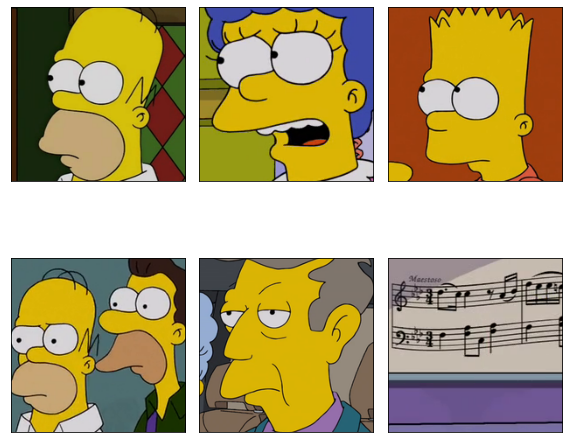

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(imread(data.File_Path[i]))
plt.tight_layout()
plt.show()

In [5]:
images = data.File_Path
type(images) 

pandas.core.series.Series

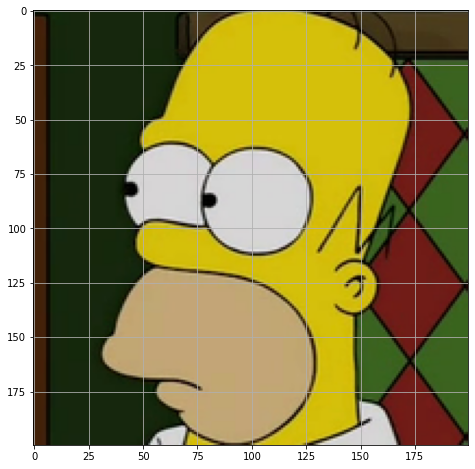

In [6]:
image_sample = imread(images[0])
plt.imshow(image_sample)
x_dim, y_dim, _ = image_sample.shape

In [7]:
image_resize_shape = (64, 64, 3)
x = np.array([resize(imread(file_path), image_resize_shape, anti_aliasing=True) 
                for file_path in data.File_Path])

## Train-Test split

In [8]:
n_samples = x.shape[0]  # The total number of samples in the dataset

## Generate a random generator with a fixed seed
rand_gen = np.random.RandomState(0)

## Generating a shuffled vector of indices
indices = np.arange(n_samples)
rand_gen.shuffle(indices)

## Split the indices into 90% train / 10% test
train_indices = indices[:int(0.9 * n_samples)]
test_indices = indices[int((0.9) * n_samples):]


## Extract the sub datasets from the full dataset using the calculated indices
x_train = x[train_indices]
x_test = x[test_indices]

## Naive PCA Compression
We will try first, a naive PCA fit, in order to do it we first resize the images into 64\*64\*3 since we don't have enough RAM to run the original size


In [9]:
from sklearn.decomposition import PCA
image_resize_shape = (64, 64, 3)

def image_to_resized_vector_transform(image_path):
  image = resize(imread(image_path), image_resize_shape, anti_aliasing=True)
  return image.reshape(-1)

X = x_train.reshape(x_train.shape[0], -1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


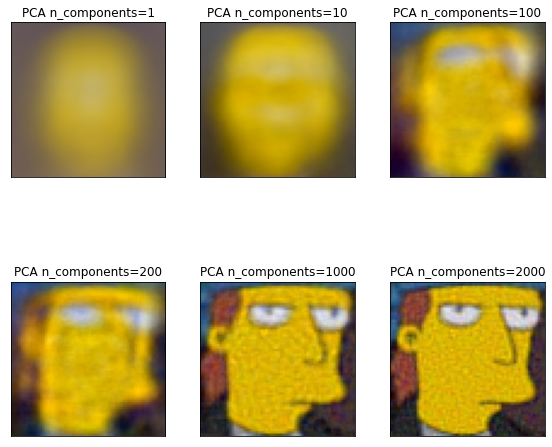

In [10]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
n_components = [1, 10, 100, 200, 1000, 2000]
for i, ax in enumerate(axes.flat):
    pca = PCA(n_components=n_components[i])
    pca.fit(X)
    reconstructed_image = pca.inverse_transform(pca.transform(x_test[0:1].reshape(1,-1)))
    ax.imshow(reconstructed_image.reshape(image_resize_shape))
    ax.set_title("PCA n_components={}".format(n_components[i]))
plt.tight_layout()
plt.show()

We see some noise even when n_components=2000, compression ratio in this case is ~ 64\*64\*3\/2000 = 6
In a standard jpeg compression we get ~ 8.4 compression ratio for the same picture.

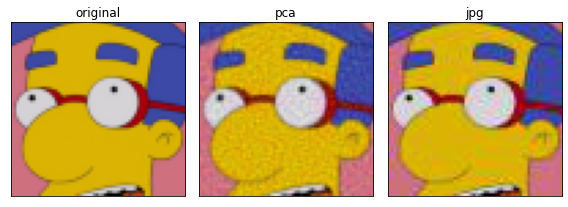

>>> ls -l compressed.jpg
-rw-r--r-- 1 root root 1853 Jul  1 06:37 compressed.jpg


In [11]:
from skimage.io import imsave, imread


imsave('compressed.jpg', X[0].reshape(image_resize_shape))
jpg_image = imread('compressed.jpg')
reconstructed_pca_image = pca.inverse_transform(pca.transform(X[0:1]))

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
title = ["original", "pca", "jpg"]
images_to_show = [X[0].reshape(image_resize_shape), reconstructed_pca_image.reshape(image_resize_shape), jpg_image]
for i, ax in enumerate(axes.flat):
    ax.imshow(images_to_show[i])
    ax.set_title(title[i])
plt.tight_layout()
plt.show()
print(">>> ls -l compressed.jpg")
!ls -l compressed.jpg

#Building Autoencoder

In [16]:
class CNN_AE(torch.nn.Module):

    def __init__(self):   
        super(CNN_AE, self).__init__()
        
        ## Defining the convolutional and pooling layers with their parameters
        ## ===========================================================================
        self.conv1 = torch.nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        self.conv2 = torch.nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2)
        self.conv3 = torch.nn.Conv2d(in_channels=64, out_channels=16, kernel_size=3, padding=1, stride=2)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2)
        self.t_conv3 = torch.nn.ConvTranspose2d(in_channels=16, out_channels=64, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.t_conv2 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=2, output_padding=1)
        self.t_conv1 = torch.nn.ConvTranspose2d(in_channels=64, out_channels=3, kernel_size=3, padding=1)

    def forward(self, x):
        # Encoder
        x = x.transpose(1,3)  # 3*64*64
        z = self.conv1(x) # 64*64*64
        z = torch.nn.functional.relu(z)
        z = self.pool(z)  # 64*32*32
        z = self.conv2(z) # 64*16*16
        z = torch.nn.functional.relu(z)
        z = self.conv3(z) # 16*8*8
        z = torch.nn.functional.relu(z)
        
        # Decoder
        z = self.t_conv3(z)
        z = torch.nn.functional.relu(z)
        z = self.t_conv2(z)
        z = torch.nn.functional.relu(z)
        z = torch.nn.functional.upsample(z, scale_factor=2, mode='nearest')
        z = self.t_conv1(z)
        z = torch.nn.functional.sigmoid(z)
        return z.transpose(1,3)


model = CNN_AE()
print(model)

CNN_AE(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv3): Conv2d(64, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_conv3): ConvTranspose2d(16, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv2): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  (t_conv1): ConvTranspose2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


## Creating Loader

In order to run over the dataset using mini batches PyTorch offers the class of [**torch.utils.data.DataLoader**](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) which receives a PyTorch dataset and generates a series of batches running over the dataset.



In [17]:
batch_size = 256
train_set = torch.utils.data.TensorDataset(torch.tensor(x_train).float())
train_loader = torch.utils.data.DataLoader(dataset=train_set, batch_size=batch_size, shuffle=True)

  0%|          | 0/2000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


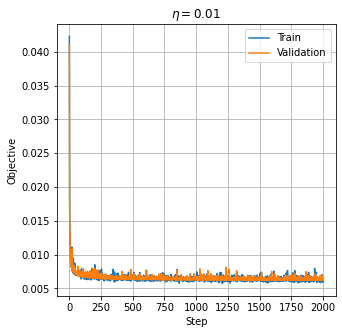

In [18]:
def train(model, eta, n_epochs, train_loader, x_val):
    ## Move validation set to the GPU
    x_val = x_val.cuda()
    
    ## Initizalie the optimizer
    # optimizer = torch.optim.SGD(model.parameters(), lr=eta)
    optimizer = torch.optim.Adam(model.parameters(), lr=eta)

    ## Prepare lists to store intermediate obejectives
    train_objective_list = [np.inf]
    val_objective_list = [np.inf]
    
    ## Run for n_epochs
    for epoch in tqdm.tqdm(range(n_epochs)):
        ## Run over the batches
        for x in train_loader:

            ## Move batch to GPU
            x = x[0].cuda()
            
            optimizer.zero_grad()
            ## Forward pass
            x_hat = model(x)
            objective = torch.nn.functional.mse_loss(x_hat, x)
            ## Backward pass
            objective.backward()
            ## Preform the gradient descent step
            optimizer.step()
    
        ## Evaluate the objective on the validation set
        with torch.no_grad(): ## This tell PyTorch not to calculate the gradients to save time
            train_objective_list.append(objective.item())

            x_val_hat = model(x_val)
            objective = torch.nn.functional.mse_loss(x_val_hat, x_val)
            val_objective_list.append(objective.item())

    return train_objective_list, val_objective_list

## Test the train function
eta = 0.01
n_epochs = 2000
model = CNN_AE()
try:
  model = model.cuda()
except:
  print("No gpu found, using cpu")
train_objective_list, val_objective_list = train(model, eta, n_epochs, train_loader,
                                                 torch.tensor(x_test).float())

## Plot
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(np.arange(len(train_objective_list)), train_objective_list, label='Train')
ax.plot(np.arange(len(val_objective_list)), val_objective_list, label='Validation')
ax.set_title(r'$\eta={' + f'{eta:g}' + r'}$')
ax.set_xlabel('Step')
ax.set_ylabel('Objective')
ax.legend();

##Show some images from the test set

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3704: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


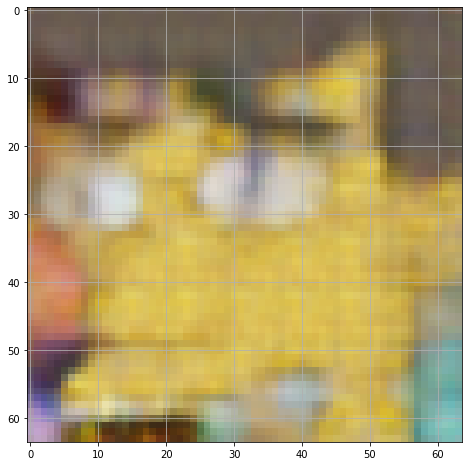

In [19]:
x = torch.tensor(x_test).float()[1:2].cuda()
x_hat = model(x)
with torch.no_grad():
  plt.imshow(x_hat.cpu().numpy()[0])

##Saving the model

In [20]:
PATH = './simpsons_autoencoder.pth'
torch.save(model.state_dict(), PATH)

##Compare images

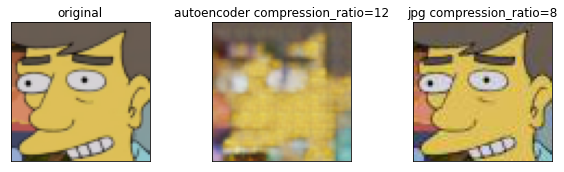

>>> ls -l compressed.jpg
-rw-r--r-- 1 root root 1899 Jul  1 08:53 compressed.jpg


In [23]:
imsave('compressed.jpg', x.cpu().numpy()[0])
jpg_image = imread('compressed.jpg')

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(8, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
title = ["original", "autoencoder compression_ratio=12", "jpg compression_ratio=8"]
with torch.no_grad():
  images_to_show = [x.cpu().numpy()[0], x_hat.cpu().numpy()[0], jpg_image]
for i, ax in enumerate(axes.flat):
    with torch.no_grad():
      ax.imshow(images_to_show[i])
    ax.set_title(title[i])
plt.tight_layout()
plt.show()
print(">>> ls -l compressed.jpg")
!ls -l compressed.jpg

#Comparing The Models and Summary

```
                  |   jpg | pca | autoencoder
Compression Ratio |   8   | 6   | 12
```

We build our models with the above compression ratios.

For the pca we saw some noising artifacts and the image looks worse than the jpg
format.

With the autoencoder we managed to achieve compression ratio = 12, we trained the model for 2000 epochs and got a blurry image.
according to the objective graph we see that we can still keep training and with the validation set given, since we haven't converged yet neither diverge, we will be able to get better results.